In [43]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import csv  
from PIL import Image
from collections import Counter
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import time
import collections
from keras.utils import to_categorical
from tqdm import tqdm
from imblearn.under_sampling import NearMiss
from sklearn.utils import shuffle

In [44]:
DIRECTORY = r'C:\Users\hp\Documents\Dataset(ORIGINAL)\train'
train_labels = r"C:\Users\hp\Documents\Dataset(ORIGINAL)\train.csv"
IMG_SIZE = 224
CHANNELS = 3
CLASSES = 3

In [45]:
Labels = pd.read_csv(train_labels)
Labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [46]:
Labels.shape

(88702, 2)

In [47]:
Labels.columns

Index(['image', 'level'], dtype='object')

In [48]:
Labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88702 entries, 0 to 88701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   88702 non-null  object
 1   level   88702 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [49]:
Labels.dtypes

image    object
level     int64
dtype: object

In [50]:
Labels.isnull().any()

image    False
level    False
dtype: bool

array([[<AxesSubplot:title={'center':'level'}>]], dtype=object)

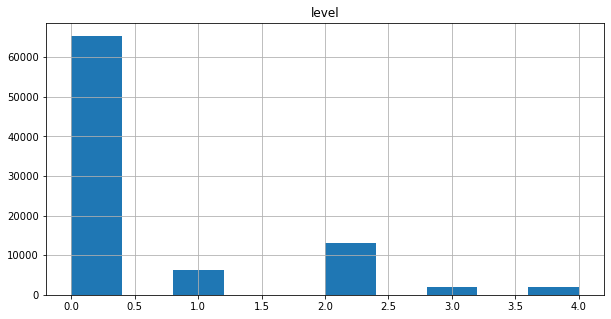

In [51]:
Labels[['level']].hist(figsize = (10, 5))

In [52]:
Labels.level.value_counts()

0    65343
2    13153
1     6205
3     2087
4     1914
Name: level, dtype: int64

In [53]:
if(len(os.listdir(DIRECTORY)) == len(Labels)):
    print("Number of images and labels match")
else:
    print("Number of images and labels DO NOT match")
    print("All labels add upto: " + str(len(Labels)))
    print("All Images add upto: " + str(len(os.listdir(DIRECTORY))))

Number of images and labels match


In [54]:
def dr_level(img):
    filename = img.split('.')[0]
    train_label = Labels.loc[Labels.image==filename, 'level'].values[0]
    return train_label

In [55]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [56]:
def read_img(img): 
    image = os.path.join(DIRECTORY, img)
    image = cv2.imread(image,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_AREA)
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image , (0,0), 30) ,-4 ,128)
    return image

In [57]:
train_labels = list() 
train_images = list() 
train_data0 = list()
train_data1 = list()
train_data2 = list()
train_data3 = list()
train_data4 = list()
Undersample = 1914

for img in tqdm(os.listdir(DIRECTORY)):
    trainLabel = dr_level(img)
    if(trainLabel==0):
        if(len(train_data0)<Undersample):
            trainLabel = 0
            img_arr = read_img(img)
            train_images.append(img_arr)
            train_labels.append(trainLabel)
            train_data0.append(trainLabel)
    
    elif(trainLabel==1):
         if(len(train_data1)<Undersample):
            trainLabel = 1
            img_arr = read_img(img)
            train_images.append(img_arr)
            train_labels.append(trainLabel)
            train_data1.append(trainLabel)
            
    elif(trainLabel==2):
        if(len(train_data2)<Undersample):
            trainLabel = 2
            train_images.append(img_arr)
            train_labels.append(trainLabel)
            train_data2.append(trainLabel)
            
    elif(trainLabel==3):
        if(len(train_data3)<Undersample):
            trainLabel = 3
            img_arr = read_img(img)
            train_images.append(img_arr)
            train_labels.append(trainLabel)
            train_data3.append(trainLabel)

    elif(trainLabel==4):
        if(len(train_data4)<Undersample):
            trainLabel = 4
            img_arr = read_img(img)
            train_images.append(img_arr)
            train_labels.append(trainLabel)
            train_data4.append(trainLabel)


100%|████████████████████████████████████████████████████████████████████████████| 88702/88702 [52:47<00:00, 28.00it/s]


In [58]:
collections.Counter(train_labels)

Counter({0: 1914, 2: 1914, 1: 1914, 4: 1914, 3: 1914})

In [59]:
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

In [60]:
print(train_images.shape, train_labels.shape)

(9570, 224, 224, 3) (9570,)


In [61]:
pickle.dump(train_images, open('DR_train_images.pkl','wb'))
pickle.dump(train_labels, open('DR_train_labels.pkl','wb'))

In [62]:
train_images = pickle.load(open('DR_train_images.pkl','rb'))
train_labels = pickle.load(open('DR_train_labels.pkl','rb'))

In [63]:
data,Label = shuffle(train_images,train_labels, random_state=2)
training_data = [data,Label]
type(training_data)
(X, y) = (training_data[0],training_data[1])

In [64]:
X = np.array(X)
y = np.array(y)

In [65]:
print("Max value element : ", X.max())
print("Min value element : ", X.min())

Max value element :  255
Min value element :  0


In [66]:
X = X.reshape(len(X),IMG_SIZE,IMG_SIZE,CHANNELS)

In [ ]:
X = X.astype('float32')

In [ ]:
X = X/255

In [ ]:
pickle.dump(X, open('X.pkl','wb'))
pickle.dump(y, open('y.pkl','wb'))